### 1. Climate Analysis and Exploration

In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.dates as mdates
import pprint

#### 1.1. Database connection
* Connect to the sqlite database
* Reflect tables into classes and save a reference to those classes
* Create a session

In [2]:
# Create engine connection
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [3]:
Base.classes.keys()

['measurement', 'station']

In [4]:
# Assign the classes to variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
# Create a session
session = Session(engine)

#### 1.2. Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.
* Select only the date and prcp values.
* Load the query results into a Pandas DataFrame and set the index to the date column.
* Plot the results using the DataFrame plot method.
* Use Pandas to print the summary statistics for the precipitation data.

In [6]:
# Find the latest date of record
latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The last date of record is {latest}.")

# Date 12 months before the last date of record
date_start_query = (latest - dt.timedelta(days=365))
print(f"Therefore, query begins on {date_start_query}.")

The last date of record is 2017-08-23.
Therefore, query begins on 2016-08-23.


Note that we did not specify a station for this analysis. So here is the plan:

* For visualization, precipitation values were averaged across stations for each day in the record.
* For statistics, raw precipitation values were used.

In [7]:
# Query date and prcp
date_prcp = pd.read_sql("select date, prcp from measurement \
                        where date >= '2016-08-23';", conn)

# Average prcp across stations
date_prcp_avg = date_prcp.groupby(["date"]).mean()
date_prcp_avg.head()

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


Visualization using matplotlib, which is easy to format x-tick labels

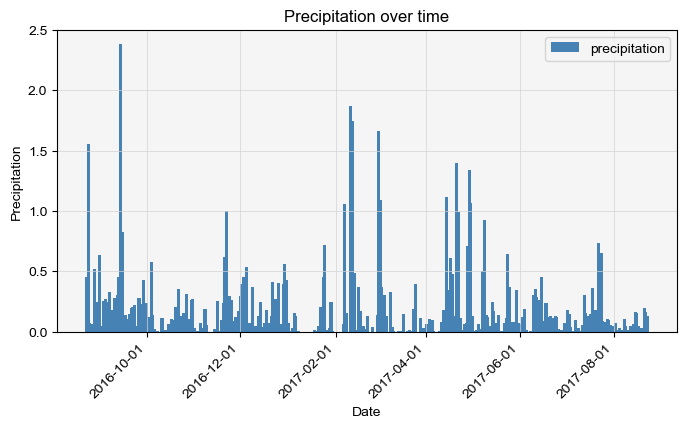

In [8]:
mpl.rcParams['figure.dpi']= 100
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
import matplotlib.dates as mdates

#plot data
plt.figure(figsize=(8,4))
plt.bar(pd.to_datetime(date_prcp_avg.index), date_prcp_avg["prcp"], color="steelblue", 
        width=2, label="precipitation")
plt.gca().set_facecolor("whitesmoke")

# Format x-tick label
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha="right")

# Other formatting
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation over time")
plt.legend(frameon=True, facecolor="whitesmoke")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')

Visualization using dataframe plot, which is not as flexible in formatting x-tick labels

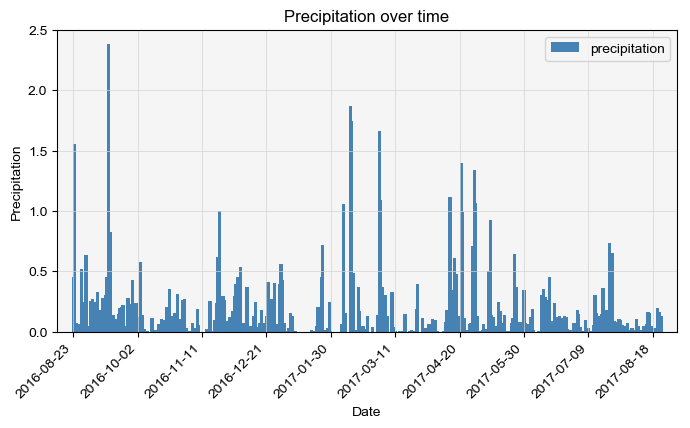

In [9]:
mpl.rcParams['figure.dpi']= 100
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']

#plot data
ax = date_prcp_avg.plot(kind="bar", color="steelblue", 
        width=2, figsize=(8,4))
plt.gca().set_facecolor("whitesmoke")

# Format x-tick label
locs = ax.xaxis.get_ticklocs()
labels = [ticklabel.get_text() for ticklabel in ax.xaxis.get_ticklabels()]
plt.xticks(locs[::40], labels[::40], rotation=45, ha="right")

# Other formatting
plt.xlim((-10, locs[-1]+10))
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation over time")
plt.legend(["precipitation"], frameon=True, facecolor="whitesmoke")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
plt.savefig('Results/prcp_date.png', bbox_inches="tight", dpi = 300)

Summary statistics

In [10]:
date_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### 1.3. Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order

  * Which station has the highest number of observations?

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

In [11]:
# Query number of stations
num_stations = session.query(func.count(Station.station)).all()[0][0]
print(f"There are {num_stations} stations in total.")

There are 9 stations in total.


In [12]:
# Query most active station
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)). \
                    group_by(Measurement.station). \
                    order_by(func.count(Measurement.prcp).desc()).all()
pprint.pprint(active_stations)
print(f"\nStation {active_stations[0][0]} has the highest number of observations.")

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

Station USC00519281 has the highest number of observations.


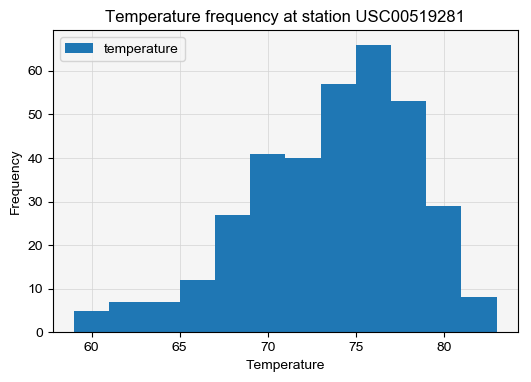

In [13]:
# Query temperatures
tobs_raw = session.query(Measurement.tobs). \
    filter(Measurement.date >= date_start_query). \
    filter(Measurement.station == active_stations[0][0]).all()

# Store temperatures in a list
tobs = [temp[0] for temp in tobs_raw]

# Plot
plt.hist(tobs, bins=12, label="temperature")
plt.gca().set_facecolor("whitesmoke")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Temperature frequency at station {active_stations[0][0]}")
plt.legend(frameon=True, facecolor="whitesmoke")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
plt.gca().set_axisbelow(True)
plt.savefig('Results/temp_hist.png', bbox_inches="tight", dpi = 300)

#### 1.4. Temperature Analysis

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [14]:
# Write the function
def calc_temps(start_date, end_date):
    
    '''
    inputs 
    start_date (str): trip start date in the format %Y-%m-%d
    end_date (str): trip end date in the format %Y-%m-%d
    
    outputs:
    temps (tuple): tuple of min, mean, and max temperatures for that range of dates
    '''
    
    start_date_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = dt.datetime.strptime(end_date, '%Y-%m-%d')

    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    temps = session.query(*sel). \
                filter(Measurement.date>=start_date_dt). \
                filter(Measurement.date<=end_date_dt).all()[0]
    
    return temps

In [15]:
# My trip
start_date = "2017-03-01"
end_date = "2017-03-14"
[temp_min, temp_avg, temp_max] = calc_temps(start_date, end_date)

print(f"My trip starts on {start_date} and ends on {end_date}. \
For the range of dates, the min temperature is {temp_min}, \
mean temperature is {temp_avg}, and maximum temperature is {temp_max}.")

My trip starts on 2017-03-01 and ends on 2017-03-14. For the range of dates, the min temperature is 62.0, mean temperature is 71.31884057971014, and maximum temperature is 82.0.


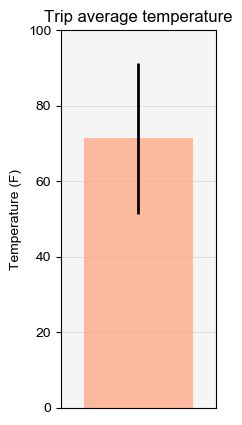

In [16]:
# Plot
plt.figure(figsize=(2,5))
plt.bar(0, temp_avg, color="lightsalmon", width=1.4, 
        alpha=0.7, yerr=temp_max-temp_min, error_kw={"linewidth":2})
plt.gca().set_facecolor("whitesmoke")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
plt.gca().set_axisbelow(True)
plt.gca().set_xticks([])
plt.xlim((-1, 1))
plt.ylim((0, 100))
plt.ylabel("Temperature (F)")
plt.title("Trip average temperature")
plt.savefig('Results/temp_avg.png', bbox_inches="tight", dpi = 300)

#### 1.5. Optional recommended analysis

* Calculate the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

  * Create a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

  * Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

  * Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

  * Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [17]:
# Average rainfall per weather station during the range of dates
start_date_dt = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = dt.datetime.strptime(end_date, '%Y-%m-%d')

session.query(Measurement.station, func.avg(Measurement.prcp)). \
            filter(Measurement.date.between(start_date_dt, end_date_dt)). \
            group_by(Measurement.station). \
            order_by(func.avg(Measurement.prcp).desc()).all()

[('USC00513117', 0.2738461538461538),
 ('USC00519281', 0.25230769230769223),
 ('USC00519523', 0.21625),
 ('USC00516128', 0.13636363636363638),
 ('USC00517948', 0.12800000000000003),
 ('USC00519397', 0.11923076923076922),
 ('USC00514830', 0.105)]

In [18]:
# Create a function
def daily_normals(date1):
    
    '''
    input
    date1 (str): a specific date in the format %m-%d
    
    output
    temps (tuple): tuple of min, avg, and max temperature of the specific date
    '''
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    temps = session.query(*sel). \
                    filter(func.date(Measurement.date).like(f'%{date1}%')).all()[0]
    return temps

In [19]:
# Daily normals
dates = ["02-01", "02-02", "02-03", "02-04", "02-05", "02-06", "02-07"]
normals = [daily_normals(date1) for date1 in dates]

# To dataframe
df_normals = pd.DataFrame(normals, index=dates, columns=["min", "avg", "max"])
df_normals

,min,avg,max
02-01,56.0,67.924528,78.0
02-02,59.0,68.820000,76.0
02-03,58.0,67.622642,77.0
02-04,61.0,68.153846,76.0
02-05,59.0,69.294118,77.0
02-06,58.0,70.288462,77.0
02-07,60.0,68.849057,77.0


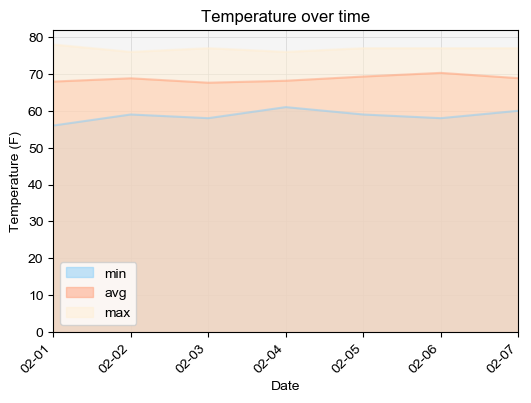

In [20]:
# Plot
df_normals.plot.area(stacked=False, color=["lightskyblue", "lightsalmon", "papayawhip"])

ax = plt.gca()
ax.set_facecolor("whitesmoke")

# Format x-tick label
locs = ax.xaxis.get_ticklocs()[1:-1]
plt.xticks(locs, df_normals.index, rotation=45, ha="right")

# Other formatting
plt.xlim((locs[0], locs[-1]))
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.title("Temperature over time")
plt.grid(linestyle='-', linewidth='0.5', color='lightgrey')
ax.set_axisbelow(True)
plt.savefig('Results/daily_normals.png', bbox_inches="tight", dpi = 300)

### 2. Climate App

#### This part is in file [hawaii_app.py](hawaii_app.py)